# 18. Expanded Utility Metrics

Notebook 07 showed that MSE is too coarse to distinguish unlearning methods (all within 0.1% of baseline). This notebook adds domain-relevant metrics that can detect latent damage:

- **Held-out ELBO** (proper generative metric, not just reconstruction)
- **Silhouette score** on latent representations vs Leiden labels
- **ARI** (Adjusted Rand Index) between k-means on latents and original clusters
- **Marker gene Pearson correlation** (per-gene, true vs reconstructed)

In [1]:
import sys
sys.path.insert(0, '../src')

import json
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from vae import VAE, vae_loss

DATA_PATH = Path('../data/adata_processed.h5ad')
OUTPUTS_PATH = Path('../outputs')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cpu


## 1. Load data and models

In [2]:
# Load data
adata = sc.read_h5ad(DATA_PATH)
X = torch.tensor(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, dtype=torch.float32)
gene_names = adata.var_names.tolist()
leiden_labels = adata.obs['leiden'].values
print(f"Data: {X.shape}")
print(f"Leiden clusters: {len(np.unique(leiden_labels))}")

# Load structured split
with open(OUTPUTS_PATH / 'p1' / 'split_structured.json', 'r') as f:
    split = json.load(f)

retain_idx = split['retain_indices']
unseen_idx = split['unseen_indices']

# Use unseen set for held-out evaluation (never trained on by any model)
holdout_idx = unseen_idx
X_holdout = X[holdout_idx]
labels_holdout = leiden_labels[holdout_idx]
print(f"Holdout set: {len(holdout_idx)} cells")

Data: torch.Size([33088, 2000])
Leiden clusters: 14
Holdout set: 4964 cells


In [3]:
def load_vae(checkpoint_path: Path) -> VAE:
    """Load VAE from checkpoint."""
    model = VAE(
        input_dim=2000,
        latent_dim=32,
        hidden_dims=[1024, 512, 128],
        dropout=0.1,
        use_layer_norm=True
    )
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    model.train(False)
    return model

# All model checkpoints
model_paths = {
    'Baseline': OUTPUTS_PATH / 'p1' / 'baseline' / 'best_model.pt',
    'Retrain': OUTPUTS_PATH / 'p1' / 'retrain_structured' / 'best_model.pt',
    'Extra-grad': OUTPUTS_PATH / 'p2' / 'adversarial_sweep' / 'extragradient_lambda10_model.pt',
    'Fisher': OUTPUTS_PATH / 'p2' / 'fisher_v2_correct' / 'unlearned_model.pt',
    'Retain-FT': OUTPUTS_PATH / 'p2' / 'retain_finetune' / 'model.pt',
    'Grad-Ascent': OUTPUTS_PATH / 'p2' / 'gradient_ascent' / 'model.pt',
}

models = {}
for name, path in model_paths.items():
    if path.exists():
        models[name] = load_vae(path)
        print(f"Loaded: {name}")
    else:
        print(f"Not found: {name} ({path})")

Loaded: Baseline
Loaded: Retrain
Loaded: Extra-grad
Loaded: Fisher
Loaded: Retain-FT
Loaded: Grad-Ascent


## 2. Compute metrics

In [4]:
# Marker genes for PBMC cell types
MARKER_GENES = ['CD3D', 'CD3E', 'MS4A1', 'CD79A', 'CD14', 'LYZ', 'NKG7', 'GNLY']
marker_idx = [gene_names.index(g) for g in MARKER_GENES if g in gene_names]
print(f"Marker genes found: {len(marker_idx)}/{len(MARKER_GENES)}")

def compute_held_out_elbo(model, X, device, batch_size=512):
    """Compute mean ELBO on held-out data."""
    model.train(False)
    total_loss = 0
    total_recon = 0
    total_kl = 0
    n = 0
    
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size].to(device)
            lib_size = batch.sum(dim=1, keepdim=True)
            output = model(batch, library_size=lib_size)
            loss, recon, kl = vae_loss(batch, output, likelihood='nb', beta=1.0)
            
            batch_n = len(batch)
            total_loss += loss.item() * batch_n
            total_recon += recon.item() * batch_n
            total_kl += kl.item() * batch_n
            n += batch_n
    
    return {
        'elbo': total_loss / n,
        'recon': total_recon / n,
        'kl': total_kl / n
    }

def compute_latent_metrics(model, X, labels, device, batch_size=512):
    """Compute silhouette score and ARI from latent space."""
    model.train(False)
    latents = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size].to(device)
            mu, _ = model.encode(batch)
            latents.append(mu.cpu().numpy())
    latents = np.concatenate(latents)
    
    # Encode labels as integers
    le = LabelEncoder()
    y = le.fit_transform(labels)
    n_clusters = len(le.classes_)
    
    # Silhouette score (how well clusters separate in latent space)
    # Use a subsample for speed
    np.random.seed(42)
    if len(latents) > 5000:
        sub_idx = np.random.choice(len(latents), 5000, replace=False)
        sil = silhouette_score(latents[sub_idx], y[sub_idx])
    else:
        sil = silhouette_score(latents, y)
    
    # ARI: k-means on latent space vs original Leiden labels
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pred_labels = kmeans.fit_predict(latents)
    ari = adjusted_rand_score(y, pred_labels)
    
    return {'silhouette': sil, 'ari': ari}

def compute_marker_correlation(model, X, marker_idx, device, batch_size=512):
    """Compute Pearson r between true and reconstructed marker gene expression."""
    model.train(False)
    recons = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size].to(device)
            mu, logvar = model.encode(batch)
            z = mu  # Use mean for deterministic evaluation
            decode_out = model.decode(z)
            if isinstance(decode_out, tuple):
                recon = decode_out[0]
            else:
                recon = decode_out
            recons.append(recon.cpu().numpy())
    recons = np.concatenate(recons)
    
    X_np = X.numpy()
    
    # Per-gene Pearson r
    correlations = []
    for idx in marker_idx:
        r, _ = pearsonr(X_np[:, idx], recons[:, idx])
        correlations.append(r)
    
    return {
        'mean_r': np.mean(correlations),
        'per_gene': dict(zip([gene_names[i] for i in marker_idx], correlations))
    }

Marker genes found: 8/8


In [5]:
# Compute all metrics for all models
all_results = {}

for name, model in models.items():
    print(f"\nComputing metrics for {name}...")
    
    elbo = compute_held_out_elbo(model, X_holdout, DEVICE)
    print(f"  ELBO: {elbo['elbo']:.2f} (recon={elbo['recon']:.2f}, kl={elbo['kl']:.2f})")
    
    latent = compute_latent_metrics(model, X_holdout, labels_holdout, DEVICE)
    print(f"  Silhouette: {latent['silhouette']:.3f}")
    print(f"  ARI: {latent['ari']:.3f}")
    
    marker = compute_marker_correlation(model, X_holdout, marker_idx, DEVICE)
    print(f"  Marker r: {marker['mean_r']:.3f}")
    
    all_results[name] = {
        'elbo': elbo['elbo'],
        'recon_loss': elbo['recon'],
        'kl': elbo['kl'],
        'silhouette': latent['silhouette'],
        'ari': latent['ari'],
        'marker_r': marker['mean_r'],
        'marker_per_gene': marker['per_gene']
    }


Computing metrics for Baseline...
  ELBO: 364.24 (recon=353.68, kl=10.55)


/Users/dbenson/.pyenv/versions/stat4243/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


  Silhouette: 0.109
  ARI: 0.452
  Marker r: 0.831

Computing metrics for Retrain...
  ELBO: 365.63 (recon=355.94, kl=9.69)
  Silhouette: 0.163
  ARI: 0.488
  Marker r: 0.829

Computing metrics for Extra-grad...
  ELBO: 477.57 (recon=475.48, kl=2.10)
  Silhouette: 0.135
  ARI: 0.497
  Marker r: 0.691

Computing metrics for Fisher...
  ELBO: 489.81 (recon=489.80, kl=0.01)
  Silhouette: 0.121
  ARI: 0.481
  Marker r: 0.628

Computing metrics for Retain-FT...
  ELBO: 363.20 (recon=352.62, kl=10.59)
  Silhouette: 0.105
  ARI: 0.461
  Marker r: 0.832

Computing metrics for Grad-Ascent...
  ELBO: 363.26 (recon=352.73, kl=10.53)
  Silhouette: 0.104
  ARI: 0.441
  Marker r: 0.832


## 3. Results

In [6]:
# Summary table
rows = []
for name, res in all_results.items():
    rows.append({
        'Method': name,
        'ELBO': res['elbo'],
        'Recon': res['recon_loss'],
        'KL': res['kl'],
        'Silhouette': res['silhouette'],
        'ARI': res['ari'],
        'Marker r': res['marker_r']
    })

df = pd.DataFrame(rows).set_index('Method')
print(df.round(4).to_string())

                 ELBO     Recon       KL  Silhouette     ARI  Marker r
Method                                                                
Baseline     364.2378  353.6836  10.5542      0.1090  0.4522    0.8313
Retrain      365.6308  355.9389   9.6919      0.1626  0.4883    0.8293
Extra-grad   477.5745  475.4773   2.0971      0.1345  0.4970    0.6914
Fisher       489.8056  489.7990   0.0066      0.1209  0.4810    0.6281
Retain-FT    363.2038  352.6183  10.5855      0.1052  0.4613    0.8321
Grad-Ascent  363.2600  352.7316  10.5283      0.1044  0.4409    0.8317


In [7]:
# Relative change vs Baseline
baseline_row = all_results.get('Baseline', {})

if baseline_row:
    print("\nRelative change vs Baseline:")
    print("-" * 70)
    print(f"{'Method':<15} {'ELBO':>8} {'Silhouette':>12} {'ARI':>8} {'Marker r':>10}")
    print("-" * 70)
    
    for name, res in all_results.items():
        if name == 'Baseline':
            continue
        
        d_elbo = res['elbo'] - baseline_row['elbo']
        d_sil = res['silhouette'] - baseline_row['silhouette']
        d_ari = res['ari'] - baseline_row['ari']
        d_marker = res['marker_r'] - baseline_row['marker_r']
        
        print(f"{name:<15} {d_elbo:>+8.2f} {d_sil:>+12.4f} {d_ari:>+8.4f} {d_marker:>+10.4f}")


Relative change vs Baseline:
----------------------------------------------------------------------
Method              ELBO   Silhouette      ARI   Marker r
----------------------------------------------------------------------
Retrain            +1.39      +0.0536  +0.0360    -0.0020
Extra-grad       +113.34      +0.0256  +0.0448    -0.1399
Fisher           +125.57      +0.0120  +0.0287    -0.2032
Retain-FT          -1.03      -0.0037  +0.0091    +0.0008
Grad-Ascent        -0.98      -0.0046  -0.0114    +0.0004


In [8]:
# Per-gene marker correlation breakdown
gene_rows = []
for name, res in all_results.items():
    for gene, r in res['marker_per_gene'].items():
        gene_rows.append({'Method': name, 'Gene': gene, 'Pearson r': r})

df_genes = pd.DataFrame(gene_rows)
df_pivot = df_genes.pivot(index='Gene', columns='Method', values='Pearson r')
print("Per-gene marker correlation:")
print(df_pivot.round(4).to_string())

Per-gene marker correlation:
Method  Baseline  Extra-grad  Fisher  Grad-Ascent  Retain-FT  Retrain
Gene                                                                 
CD14      0.7982      0.7665  0.6437       0.7970     0.8002   0.7967
CD3D      0.7672      0.6025  0.6009       0.7687     0.7697   0.7609
CD3E      0.6452      0.5323  0.5515       0.6476     0.6437   0.6419
CD79A     0.9005      0.7267  0.8148       0.9010     0.9013   0.9002
GNLY      0.8997      0.6360  0.3037       0.9031     0.9034   0.8940
LYZ       0.9005      0.8754  0.8346       0.8987     0.8999   0.9008
MS4A1     0.8087      0.6934  0.7609       0.8085     0.8102   0.8118
NKG7      0.9304      0.6984  0.5145       0.9291     0.9285   0.9281


## 4. Visualization

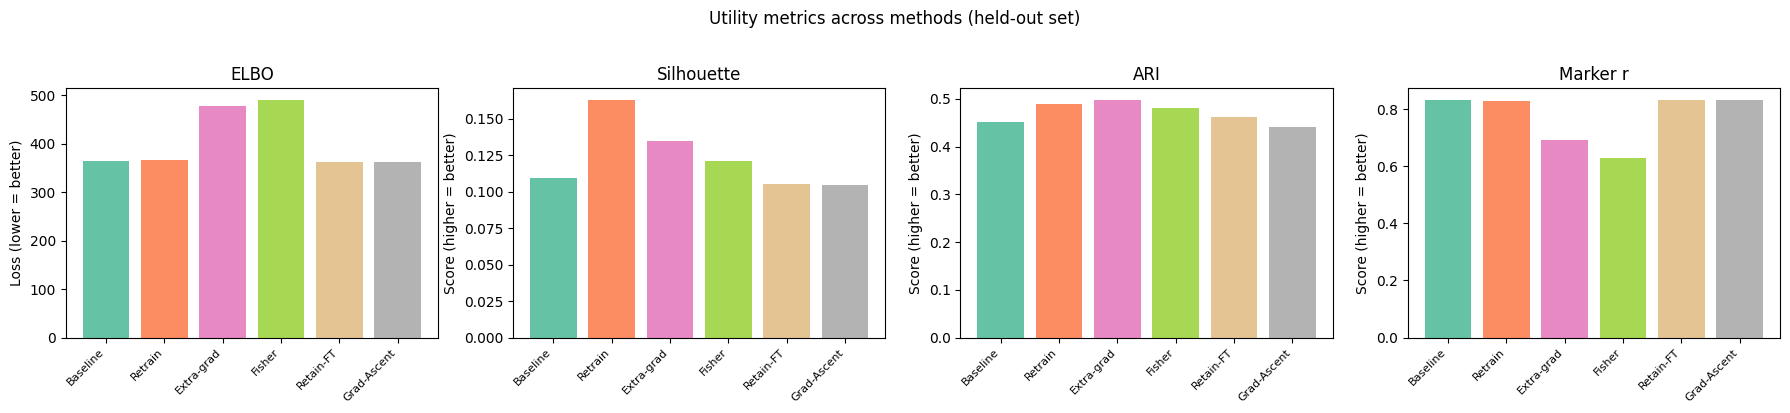

In [9]:
# Bar chart comparison
metrics = ['ELBO', 'Silhouette', 'ARI', 'Marker r']
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

method_names = list(all_results.keys())
colors = plt.cm.Set2(np.linspace(0, 1, len(method_names)))

for ax, metric in zip(axes, metrics):
    key_map = {'ELBO': 'elbo', 'Silhouette': 'silhouette', 'ARI': 'ari', 'Marker r': 'marker_r'}
    key = key_map[metric]
    vals = [all_results[m][key] for m in method_names]
    
    bars = ax.bar(range(len(method_names)), vals, color=colors)
    ax.set_xticks(range(len(method_names)))
    ax.set_xticklabels(method_names, rotation=45, ha='right', fontsize=8)
    ax.set_title(metric)
    
    # For ELBO, lower is better; for others, higher is better
    if metric == 'ELBO':
        ax.set_ylabel('Loss (lower = better)')
    else:
        ax.set_ylabel('Score (higher = better)')

plt.suptitle('Utility metrics across methods (held-out set)', y=1.02)
plt.tight_layout()
plt.savefig('../figures/utility_suite_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

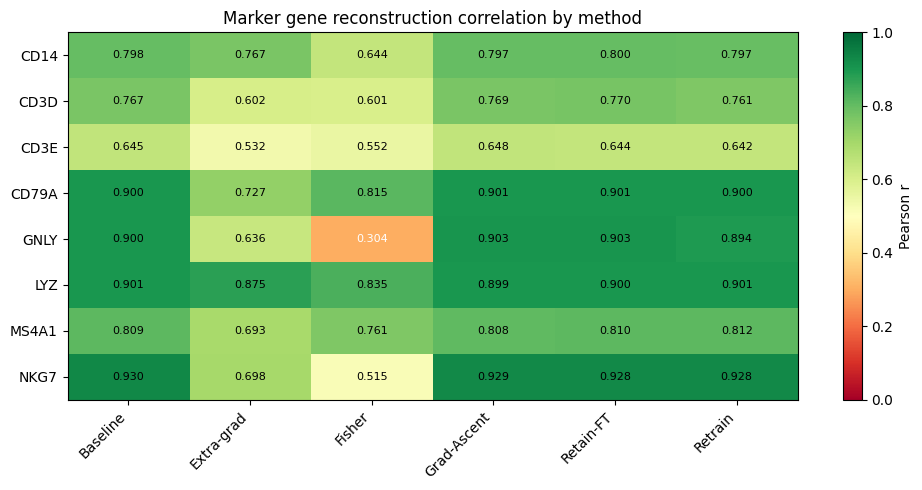

In [10]:
# Per-gene marker correlation heatmap
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(df_pivot.values, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')

ax.set_xticks(range(len(df_pivot.columns)))
ax.set_xticklabels(df_pivot.columns, rotation=45, ha='right')
ax.set_yticks(range(len(df_pivot.index)))
ax.set_yticklabels(df_pivot.index)

# Annotate cells
for i in range(len(df_pivot.index)):
    for j in range(len(df_pivot.columns)):
        val = df_pivot.values[i, j]
        color = 'white' if val < 0.5 else 'black'
        ax.text(j, i, f'{val:.3f}', ha='center', va='center', fontsize=8, color=color)

plt.colorbar(im, label='Pearson r')
ax.set_title('Marker gene reconstruction correlation by method')
plt.tight_layout()
plt.savefig('../figures/utility_marker_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Findings

The metrics split the six models into two groups.

Retain-FT and Grad-Ascent match baseline on every metric (ELBO within 1 point, marker r within 0.001, silhouette and ARI within 0.01). This is consistent with notebooks 16 and 17, which showed these methods do not modify the model enough to affect the forget set. No unlearning, no utility cost.

Extra-grad and Fisher both pay a large utility cost. ELBO increases by +113 (Extra-grad) and +126 (Fisher) over baseline, driven almost entirely by reconstruction loss. Fisher's KL of 0.007 (vs baseline 10.55) confirms posterior collapse: the encoder maps all inputs to nearly the same latent point. Extra-grad's KL of 2.10 suggests partial collapse.

Marker gene correlations show where reconstruction degrades. Fisher drops mean r from 0.831 to 0.628, with GNLY worst affected (0.304 vs 0.900). Extra-grad drops mean r to 0.691 with a similar per-gene pattern. Both methods lose the most on NK cell markers (GNLY, NKG7).

Latent structure (silhouette, ARI) changes less than reconstruction quality. Extra-grad ARI (0.497) slightly exceeds baseline (0.452), so the latent space preserves cluster geometry even as the decoder degrades.

Retrain has slightly better silhouette (0.163 vs 0.109) and ARI (0.488 vs 0.452) than baseline, with nearly identical ELBO (+1.39) and marker r (-0.002). Retraining without the forget set improves latent cluster separation at no reconstruction cost.

In [11]:
# Save results
output = {
    'holdout_size': len(holdout_idx),
    'metrics': {}
}

for name, res in all_results.items():
    output['metrics'][name] = {
        'elbo': float(res['elbo']),
        'recon_loss': float(res['recon_loss']),
        'kl': float(res['kl']),
        'silhouette': float(res['silhouette']),
        'ari': float(res['ari']),
        'marker_r': float(res['marker_r']),
        'marker_per_gene': {k: float(v) for k, v in res['marker_per_gene'].items()}
    }

with open(OUTPUTS_PATH / 'utility_suite_results.json', 'w') as f:
    json.dump(output, f, indent=2)

print(f"Saved to {OUTPUTS_PATH / 'utility_suite_results.json'}")

Saved to ../outputs/utility_suite_results.json
